In [1]:
# Linking Google drive to use preprocessed data
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Mounted at /content/drive


# II. General imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


# III. Emotic classes

## Emotic Model

In [3]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features):
    super(Emotic,self).__init__()
    self.num_context_features = num_context_features
    self.fc1 = nn.Linear((self.num_context_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()


  def forward(self, x_context):
    context_features = x_context.view(-1, self.num_context_features)
    fuse_features = torch.cat((context_features,), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cont_out

print ('completed cell')

completed cell


## Emotic Dataset

In [4]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, y_cat, y_cont, transform, context_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])           # Normalizing the context image with context mean and context std

  def __len__(self):
    return len(self.y_cat)

  def __getitem__(self, index):
    image_context = self.x_context[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Emotic Losses

In [5]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)

  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum()

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# IV. Load preprocessed data

In [6]:
# # Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/VA-prediction/dataset'

saliency_method = ''


#train
train_context = np.load(os.path.join(data_src,'pre',saliency_method + 'train_context_arr.npy'))

train_cat = np.load(os.path.join(data_src,'pre','train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'pre','train_cont_arr.npy'))


#val
val_context = np.load(os.path.join(data_src,'pre',saliency_method + 'val_context_arr.npy'))

val_cat = np.load(os.path.join(data_src,'pre','val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'pre','val_cont_arr.npy'))


#test
test_context = np.load(os.path.join(data_src,'pre',saliency_method + 'test_context_arr.npy'))\

test_cat = np.load(os.path.join(data_src,'pre','test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'pre','test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'context', train_context.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'context', val_context.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'context', test_context.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  context (23266, 224, 224, 3) cat  (23266, 26) cont (23266, 3)
val  context (3315, 224, 224, 3) cat  (3315, 26) cont (3315, 3)
test  context (7203, 224, 224, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [7]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]

context_norm = [context_mean, context_std]


train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_cat, train_cont, \
                                  train_transform, context_norm)
val_dataset = Emotic_PreDataset(val_context, val_cat, val_cont, \
                                test_transform, context_norm)
test_dataset = Emotic_PreDataset(test_context, test_cat, test_cont, \
                                 test_transform, context_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# V. PREPARE EMOTIC MODEL

## Resnet-18 (Places365)

In [8]:
# Get Resnet18 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar -O ./places/resnet18_places365.pth.tar

--2023-07-22 08:12:28--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘./places/resnet18_places365.pth.tar’

./places/resnet18_p 100%[===================>]  43.40M  48.4MB/s    in 0.9s    

2023-07-22 08:12:29 (48.4 MB/s) - ‘./places/resnet18_places365.pth.tar’ saved [45506139/45506139]



In [9]:
# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


In [10]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

print (summary(model_context, (3,224,224), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Resnet-50 (Places365)

In [ ]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

--2023-07-20 21:40:40--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  13.5MB/s    in 8.5s    

2023-07-20 21:40:49 (10.9 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [ ]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [ ]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

print (summary(model_context, (3,224,224), device="cpu"))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 78.4MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# VI. Prepare Model + Optimizer

In [11]:
emotic_model = Emotic(list(model_context.children())[-1].in_features)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + \
                  list(model_context.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


# VII. Train + Test Function

In [13]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [14]:
def test_data(models, device, data_loader, num_images):
    model_context, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        emotic_model.to(device)
        model_context.eval()
        emotic_model.eval()
        indx = 0

        print ('starting testing')
        for images_context, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)

            pred_context = model_context(images_context)
            pred_cont = emotic_model(pred_context)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [15]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_context, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)

    emotic_model.train()
    model_context.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_context, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)

      pred_cont = emotic_model(pred_context)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_context.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_context, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)

        pred_cont = emotic_model(pred_context)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 451422.9105
vad [1.6461527 2.082127  2.008322 ] (3,) 1.9122006
epoch = 0 training MAE = 1.9122
epoch = 0 validation loss = 12167.9824
vad [0.89503103 0.9507611  0.97076166] (3,) 0.9388512
epoch = 0 val MAE= 0.9389
saving model at epoch e = 0
epoch = 1 training loss = 247858.3732
vad [1.2183415 1.7118568 1.620695 ] (3,) 1.5169644
epoch = 1 training MAE = 1.5170
epoch = 1 validation loss = 10404.4612
vad [0.8552859  0.94077957 0.82914543] (3,) 0.8750703
epoch = 1 val MAE= 0.8751
saving model at epoch e = 1
epoch = 2 training loss = 230173.2299
vad [1.1647297 1.6659433 1.5529666] (3,) 1.4612131
epoch = 2 training MAE = 1.4612
epoch = 2 validation loss = 9785.2789
vad [0.8132995 0.89132   0.8516805] (3,) 0.85209996
epoch = 2 val MAE= 0.8521
saving model at epoch e = 2
epoch = 3 training loss = 221188.8584
vad [1.1385425 1.6479928 1.516879 ] (3,) 1.4344715
epoch = 3 training MAE = 1.4345
epoch = 3 validation loss = 10075.9439
vad [0.80335647 0.9133312  0.8650991 ] 

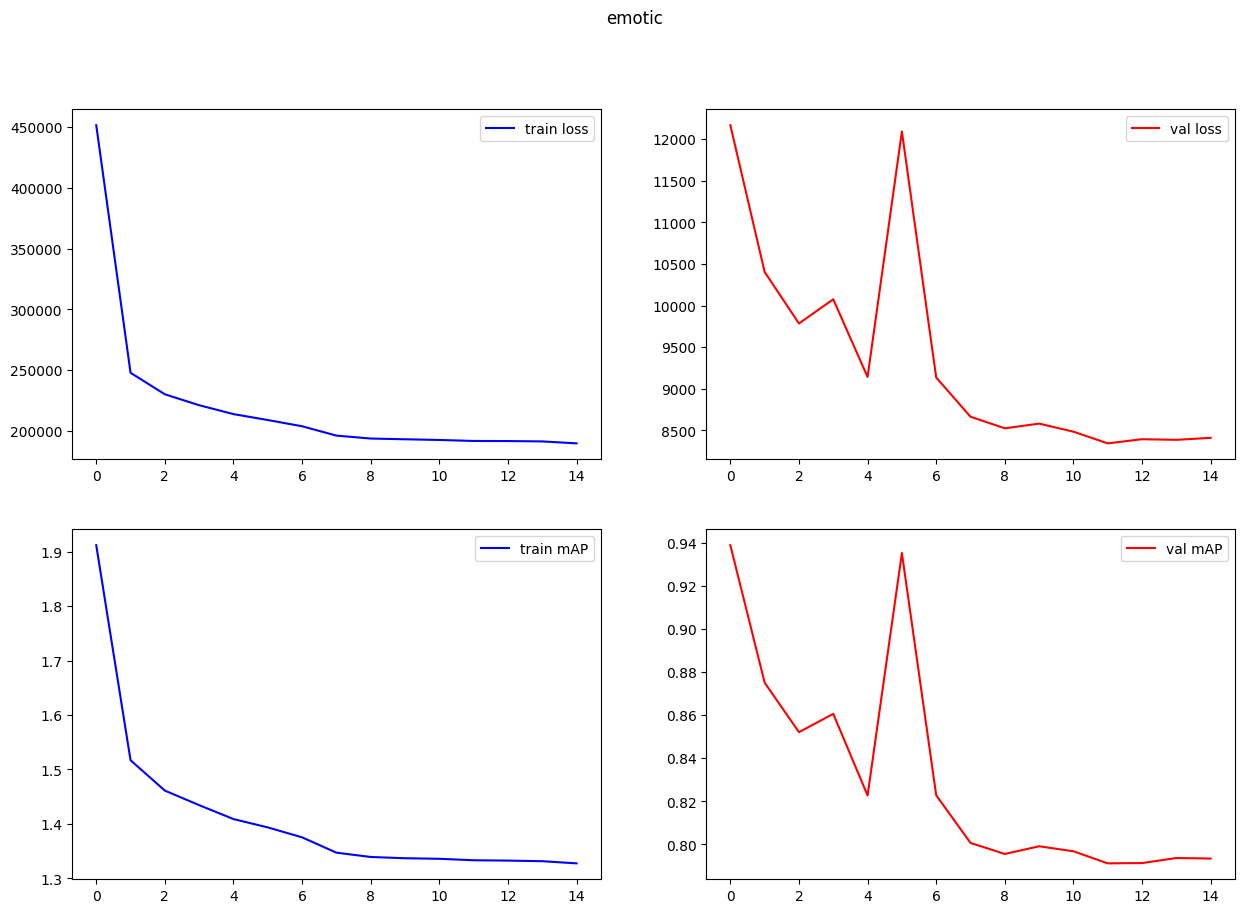

In [16]:
train_emotic(15, './models', opt, scheduler, [model_context, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [17]:
model_path = './models'
model_context = torch.load(os.path.join(model_path, 'model_context.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_context.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
test_vad = test_data([model_context, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.93454266 1.0198826  0.9475431 ] (3,) 0.96732277
0.96732277
testing MAE=0.9673


# Train 2


---



## Resnet-50 (Places365)

In [20]:
# Get Resnet50 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar -O ./places/resnet50_places365.pth.tar

mkdir: cannot create directory ‘./places’: File exists
--2023-07-22 08:43:55--  http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97270159 (93M) [application/x-tar]
Saving to: ‘./places/resnet50_places365.pth.tar’

./places/resnet50_p 100%[===================>]  92.76M  57.4MB/s    in 1.6s    

2023-07-22 08:43:57 (57.4 MB/s) - ‘./places/resnet50_places365.pth.tar’ saved [97270159/97270159]



In [21]:
# the architecture to use
arch50 = 'resnet50'
model_weight = os.path.join('./places', 'resnet50_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch50](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet50_state_dict.pth')
print ('completed cell')

completed cell


In [22]:
model_path_places = './places'

model_context = models.__dict__[arch50](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet50_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

print (summary(model_context, (3,224,224), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# VI. Prepare Model + Optimizer

In [23]:
emotic_model = Emotic(list(model_context.children())[-1].in_features)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))

for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + \
                  list(model_context.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_L2 = ContinuousLoss_L2()

print ('completed cell')

completed cell


# VII. Train + Test Function

In [25]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [26]:
def test_data(models, device, data_loader, num_images):
    model_context, emotic_model = models
    # cat_preds = np.zeros((num_images, 26))
    # cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        emotic_model.to(device)
        model_context.eval()
        emotic_model.eval()
        indx = 0

        print ('starting testing')
        for images_context, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)

            pred_context = model_context(images_context)
            pred_cont = emotic_model(pred_context)

            # cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            # cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cont.shape[0]

    # cat_preds = cat_preds.transpose()
    # cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    # scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    # scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    # scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    # scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    # ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (vad_mean)
    return vad_mean

print ('completed cell')

completed cell


In [27]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=1.0, cont_loss_param=1.0, train_length = train_dataset.__len__(), val_length = val_dataset.__len__()):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()
  train_mae = list()
  val_mae = list()
  model_context, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)

    emotic_model.train()
    model_context.train()

    train_cont_preds = np.zeros((train_length, 3))
    train_cont_labels = np.zeros((train_length, 3))
    indx = 0

    for images_context, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)

      pred_cont = emotic_model(pred_context)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = cont_loss_param * cont_loss_batch
      running_loss += loss.item()
      loss.backward()
      opt.step()
      #calculate MAE
      train_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
      train_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
      indx = indx + pred_cont.shape[0]

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)
    train_cont_preds = train_cont_preds.transpose()
    train_cont_labels = train_cont_labels.transpose()
    train_mae.append(test_emotic_vad(train_cont_preds, train_cont_labels))
    print ('epoch = %d training MAE = %.4f' %(e, train_mae[-1]))

    running_loss = 0.0
    emotic_model.eval()
    model_context.eval()

    val_cont_preds = np.zeros((val_length, 3))
    val_cont_labels = np.zeros((val_length, 3))
    indx = 0

    with torch.no_grad():
      for images_context, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)

        pred_cont = emotic_model(pred_context)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = cont_loss_param * cont_loss_batch
        running_loss += loss.item()

        val_cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
        val_cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
        indx = indx + pred_cont.shape[0]
      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)
    val_cont_preds = val_cont_preds.transpose()
    val_cont_labels = val_cont_labels.transpose()
    val_mae.append(test_emotic_vad(val_cont_preds, val_cont_labels))
    print ('epoch = %d val MAE= %.4f' %(e, val_mae[-1]))
    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context.pth'))

  print ('completed training')

  f, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize = (15, 10))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train loss'])
  ax2.legend(['val loss'])

  ax3.plot(range(0,len(train_mae)),train_mae, color='Blue')
  ax4.plot(range(0,len(val_mae)),val_mae, color='Red')
  ax3.legend(['train mAP'])
  ax4.legend(['val mAP'])

print ('completed cell')

completed cell


# VIII. Training + Testing

epoch = 0 training loss = 486027.0655
vad [1.8005091 2.0117576 2.0943906] (3,) 1.9688858
epoch = 0 training MAE = 1.9689
epoch = 0 validation loss = 15116.4459
vad [0.95363426 1.0677423  1.0769298 ] (3,) 1.0327688
epoch = 0 val MAE= 1.0328
saving model at epoch e = 0
epoch = 1 training loss = 245239.0845
vad [1.245417  1.6821979 1.6174814] (3,) 1.5150322
epoch = 1 training MAE = 1.5150
epoch = 1 validation loss = 10928.3281
vad [0.88282865 0.8862365  0.92271054] (3,) 0.8972586
epoch = 1 val MAE= 0.8973
saving model at epoch e = 1
epoch = 2 training loss = 229050.1310
vad [1.1822572 1.6513766 1.5544925] (3,) 1.4627088
epoch = 2 training MAE = 1.4627
epoch = 2 validation loss = 11324.5455
vad [0.83753467 0.86149085 0.9981492 ] (3,) 0.8990583
epoch = 2 val MAE= 0.8991
epoch = 3 training loss = 220316.8191
vad [1.1421024 1.6431705 1.5119812] (3,) 1.432418
epoch = 3 training MAE = 1.4324
epoch = 3 validation loss = 10216.1048
vad [0.79255635 0.8578383  0.94727725] (3,) 0.8658907
epoch = 3 v

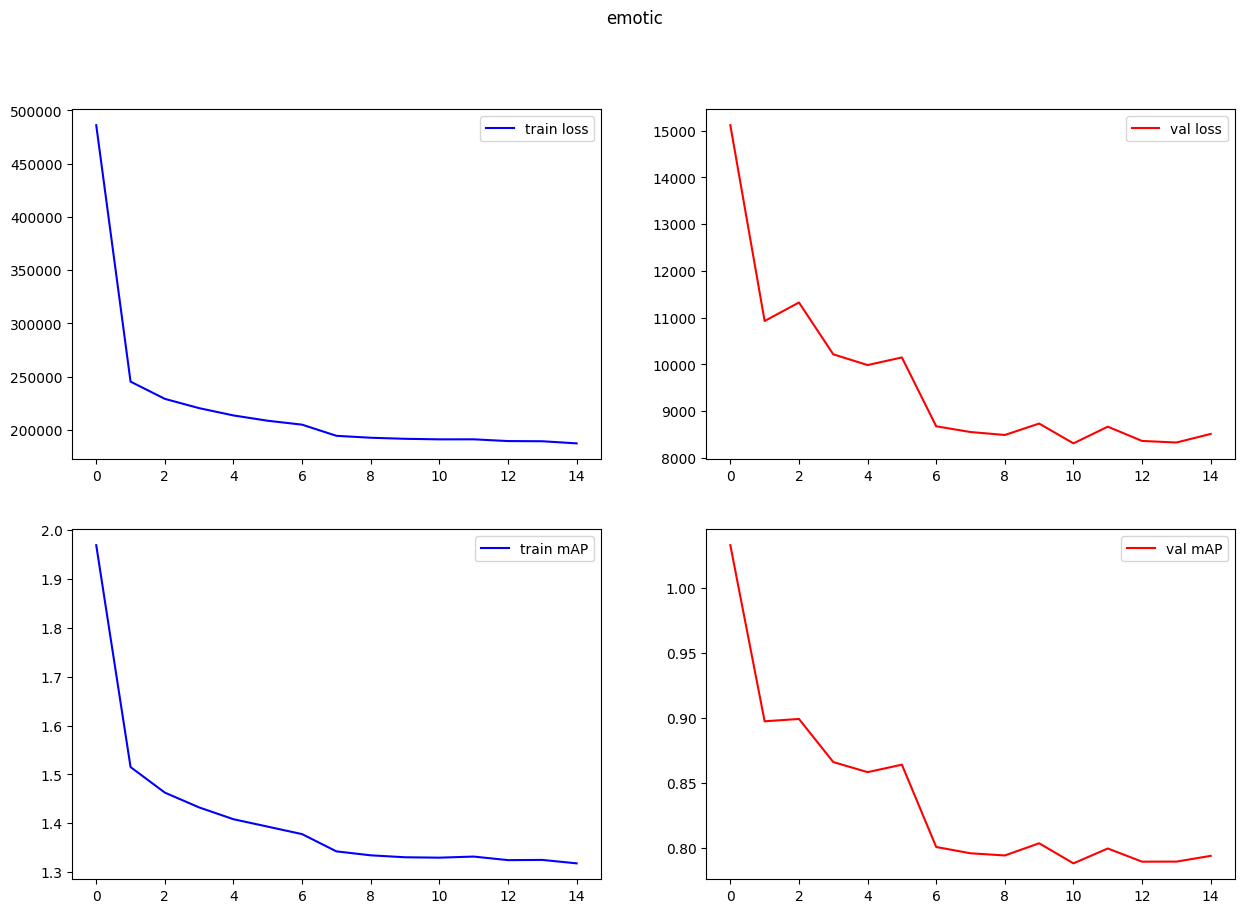

In [28]:
train_emotic(15, './models', opt, scheduler, [model_context, emotic_model], disc_loss=disc_loss, cont_loss=cont_loss_L2, cat_loss_param=1.0, cont_loss_param=1.0)

In [29]:
model_path = './models'
model_context = torch.load(os.path.join(model_path, 'model_context.pth'))
emotic_model = torch.load(os.path.join(model_path, 'model_emotic.pth'))

model_context.eval()
emotic_model.eval()

print ('completed cell')

completed cell


In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
test_vad = test_data([model_context, emotic_model], device, test_loader, test_dataset.__len__())
print ('testing MAE=%.4f' %(test_vad))

starting testing
completed testing
vad [0.9303526 1.0145463 0.9399338] (3,) 0.96161085
0.96161085
testing MAE=0.9616
